In [2]:
!pip install -q rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 17.4 MB/s eta 0:00:00


In [3]:
#Biblioteca
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [11]:
# Função para carregar um raster
def load_raster(filepath):
    with rasterio.open(filepath) as src:
        array = src.read(1).astype(np.float32)
        profile = src.profile
        transform = src.transform
        nodata = src.nodata
    return array, profile, transform, nodata

In [ ]:
# Carregar AGB (raster de referência)
agb_esa, profile_agb, transform_agb, nodata_agb = load_raster("/content/PNB_AGB.tif")

# Carregar ndvi
ndvi, profile_ndvi, transform_ndvi, nodata_ndvi = load_raster("/content/PNB_NDVI.tif")

# Criar um array vazio para armazenar o raster reprojetado
ndvi_resampled = np.empty_like(agb_esa)

# Reprojetar ndvi para coincidir com agb_ESA
reproject(
    source=ndvi,
    destination=ndvi_resampled,
    src_transform=transform_ndvi,
    src_crs=profile_ndvi["crs"],
    dst_transform=transform_agb,
    dst_crs=profile_agb["crs"],
    resampling=Resampling.nearest,
)

In [30]:
# Gravando ndvi rescalonado em disco
profile_agb["nodata"] = profile_ndvi["nodata"]
with rasterio.open("ndvi_resampled.tif", "w", **profile_agb) as dst:
    dst.write(ndvi_resampled, 1)

In [31]:
ndvi_resamp, profile_resamp, transform_resamp, nodata_resamp = load_raster("ndvi_resampled.tif")

# Criar máscara para remover NoData
mask = (agb_esa != nodata_agb) & (ndvi_resamp != nodata_resamp)

# Obter apenas os valores válidos
x_valid = agb_esa[mask].flatten()
y_valid = ndvi_resamp[mask].flatten()

# Calcular regressão linear global
slope, intercept, r_value, p_value, std_err = linregress(x_valid, y_valid)

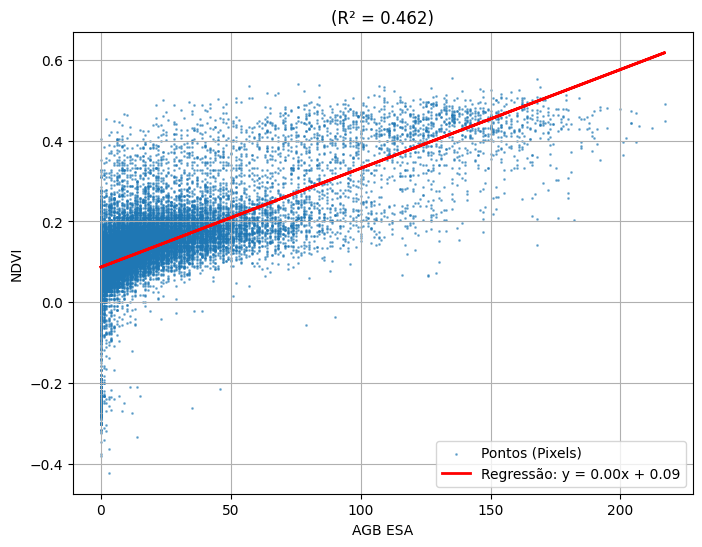

In [33]:
# Criar gráfico de dispersão
plt.figure(figsize=(8, 6))
plt.scatter(x_valid, y_valid, s=1, alpha=0.5, label="Pontos (Pixels)")
plt.plot(x_valid, slope * x_valid + intercept, color="red", linewidth=2, label=f"Regressão: y = {slope:.2f}x + {intercept:.2f}")

# Adicionar informações ao gráfico
plt.xlabel("AGB ESA")
plt.ylabel("NDVI")
plt.title(f"(R² = {r_value**2:.3f})")
plt.legend()
plt.grid()

# Mostrar gráfico
plt.show()
